# 289to305 (16-31 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct16-31woPe deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_289to305']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_289to305'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 155 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9973645159364154


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.14220996704827923


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

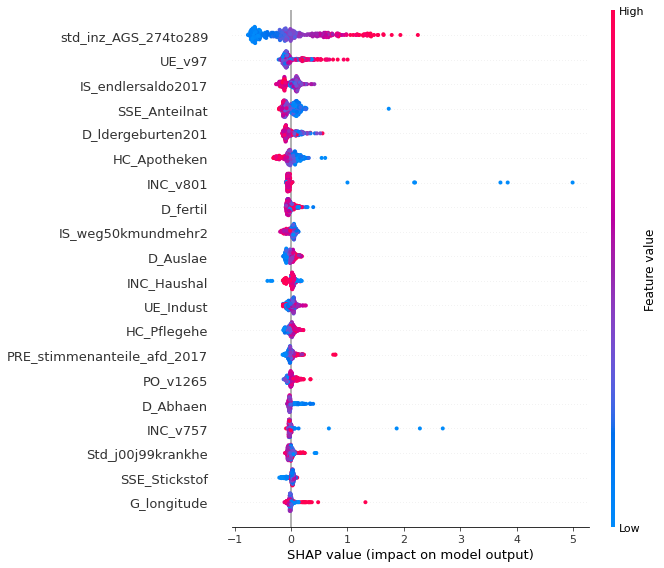

In [7]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9894508842101677


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.2845167690330909


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_274to289', 'UE_v97', 'IS_endlersaldo2017', 'SSE_Anteilnat', 'D_ldergeburten201', 'HC_Apotheken', 'INC_v801', 'D_fertil', 'IS_weg50kmundmehr2', 'D_Auslae'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_274to289', 'HC_Apotheken', 'D_Auslae', 'SSE_Anteilnat', 'INC_v801', 'UE_v97', 'INC_Haushal', 'UE_Indust', 'Std_j00j99krankhe', 'D_Abhaen']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_274to289
UE_v97
SSE_Anteilnat
HC_Apotheken
INC_v801
D_Auslae


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

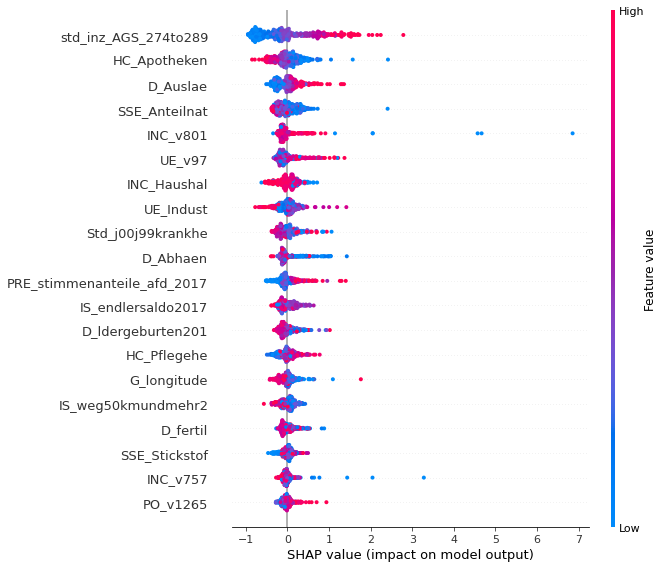

In [13]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9952440904891144
Mean R2 of linReg_modesl with top20 features:  0.1958791443355581
Mean RMSE of CatBoost_models on test sets with top20 features:  2.4560789640952025
Mean R2 of CatBoost_models on test sets with top20 features: 0.14986446884280089


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_274to289,UE_v97,IS_endlersaldo2017,SSE_Anteilnat,D_ldergeburten201,HC_Apotheken,INC_v801,D_fertil,IS_weg50kmundmehr2,D_Auslae,INC_Haushal,UE_Indust,HC_Pflegehe,PRE_stimmenanteile_afd_2017,PO_v1265,D_Abhaen,INC_v757,Std_j00j99krankhe,SSE_Stickstof,G_longitude
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,52.453857,-8.350625,-10.362344,5.101745,16.510971,27.003731,2846.079834,1.632220,11.484292,10.034916,1591.685791,18.253864,97.709465,13.388280,48.195263,34.353863,8.945634,156.736603,68.331635,9.866997
std,36.794933,18.685120,29.724245,3.710642,8.783778,4.899685,926.154114,0.134031,3.481254,5.149191,589.468811,8.723560,23.278893,5.329521,1.583288,5.474822,2.964478,33.154427,27.160891,2.026269
min,3.428815,-51.700001,-149.399994,0.900000,-9.600000,18.100000,28.000000,1.060000,4.900000,1.900000,2.000000,0.000000,40.700001,4.900000,42.799999,22.400000,-14.300000,0.000000,21.400000,6.083333
25%,26.030115,-21.000000,-25.299999,2.700000,11.700000,23.700001,2706.000000,1.560000,9.000000,6.200000,1591.000000,12.700000,80.400002,9.800000,47.400002,31.000000,7.700000,137.969284,47.500000,8.216666
50%,44.778191,-9.300000,-12.000000,4.300000,17.600000,26.100000,3052.000000,1.650000,10.800000,9.200000,1764.000000,17.200001,96.800003,12.000000,48.400002,33.799999,9.000000,155.349396,59.200001,9.766666
75%,67.134506,3.800000,4.800000,6.300000,21.900000,29.200001,3329.000000,1.720000,13.300000,13.100000,1904.000000,22.700001,113.900002,15.300000,49.200001,36.900002,10.700000,176.413727,88.199997,11.416667
max,267.674591,61.299999,62.700001,34.000000,45.500000,51.700001,4855.000000,1.940000,24.200001,35.000000,2904.000000,91.800003,184.899994,35.500000,51.900002,54.000000,24.700001,230.751968,150.699997,14.983334


In [17]:
pd.DataFrame(Y).describe()

,std_leth_AGS_289to305
count,401.000000
mean,2.464972
std,2.773588
min,0.000000
25%,0.477827
50%,1.697788
75%,3.255191
max,15.949838
